In [195]:
library(tidyverse)
library(WGCNA)
library(cowplot)

# Custom package
library(rutils)

In [256]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [197]:
dset_idx <- 1

In [273]:
filtered_matrisome_df <- load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category, gene_name, synonyms) %>%
    dplyr::filter(gene_symbol %in% colnames(matrisome_norm_counts_df))    # Only include genes in dataset

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [198]:
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


# Load data

In [199]:
tumor_coldata_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/coldata.tsv")) %>%
    dplyr::filter(condition == "tumor")
matrisome_norm_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")) %>%
    dplyr::select(one_of(c("geneID", tumor_coldata_df$sample_name))) %>%
    transpose_df(future_colnames_col = "geneID", previous_colnames_col = "sample_name")

Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  data_source = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.


# Find soft thresholding power

In [200]:
sft <- pickSoftThreshold(data = matrisome_norm_counts_df %>% column_to_rownames("sample_name"), verbose = FALSE)

   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1    0.526  1.470         0.4070 121.0000  1.19e+02 204.00
2      2    0.480 -0.917         0.9760  27.2000  2.30e+01  84.70
3      3    0.896 -1.520         0.9770   8.9500  5.87e+00  47.00
4      4    0.898 -1.620         0.9250   3.7900  1.86e+00  30.10
5      5    0.906 -1.580         0.9080   1.9000  6.86e-01  21.10
6      6    0.904 -1.580         0.9140   1.0800  2.58e-01  15.50
7      7    0.913 -1.500         0.9160   0.6660  1.06e-01  11.90
8      8    0.267 -2.210         0.1070   0.4370  4.71e-02   9.30
9      9    0.941 -1.420         0.9500   0.3020  2.24e-02   7.46
10    10    0.925 -1.400         0.9230   0.2170  1.05e-02   6.10
11    12    0.937 -1.360         0.9330   0.1220  2.36e-03   4.25
12    14    0.229 -1.710         0.0131   0.0759  5.46e-04   3.10
13    16    0.294 -1.880         0.1220   0.0508  1.50e-04   2.33
14    18    0.896 -1.290         0.8670   0.0362  4.03e-05   1.98
15    20  

In [201]:
sft_df <- sft$fitIndices %>%
    as_tibble() %>%
    rename_with(function(c) { gsub("_$", "", tolower(gsub("\\.", "_", c))) }) %>%
    dplyr::mutate(scale_free_topology = -sign(slope) * sft_r_sq)
head(sft_df)

power,sft_r_sq,slope,truncated_r_sq,mean_k,median_k,max_k,scale_free_topology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5262761,1.4721439,0.4070973,120.611123,119.1068624,204.06975,-0.5262761
2,0.4804132,-0.9166779,0.9761398,27.202508,22.9775556,84.73978,0.4804132
3,0.8963308,-1.5170361,0.9768931,8.945140,5.8725017,47.02426,0.8963308
4,0.8984734,-1.6171535,0.9250584,3.787101,1.8580945,30.07127,0.8984734
5,0.9057127,-1.5772666,0.9084639,1.904427,0.6861794,21.08367,0.9057127
6,0.9035685,-1.5817367,0.9139415,1.078940,0.2579115,15.52929,0.9035685


## Visualize

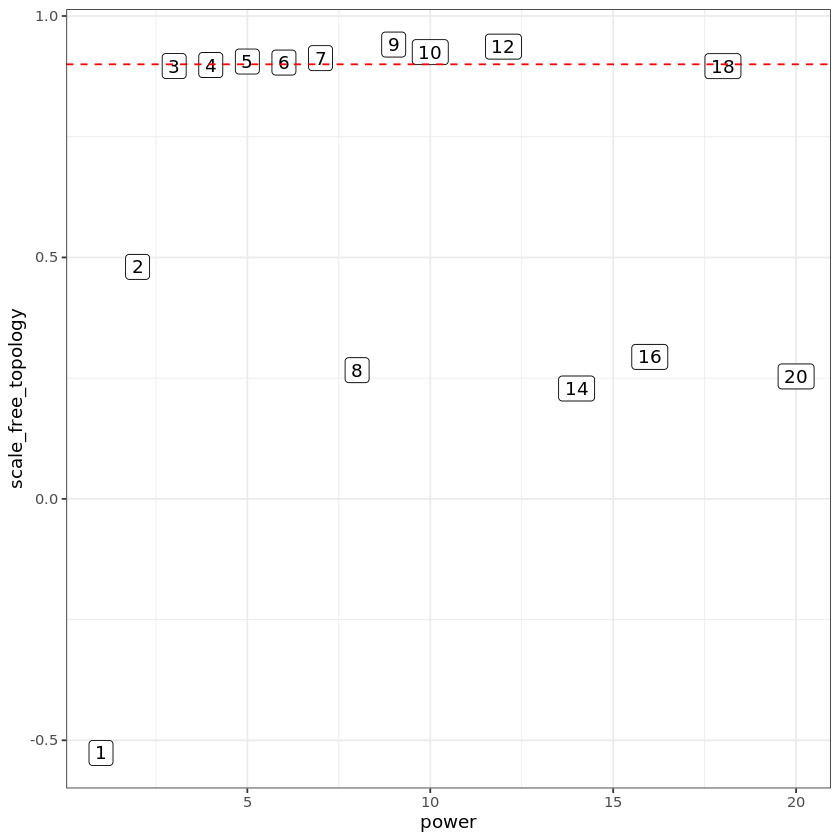

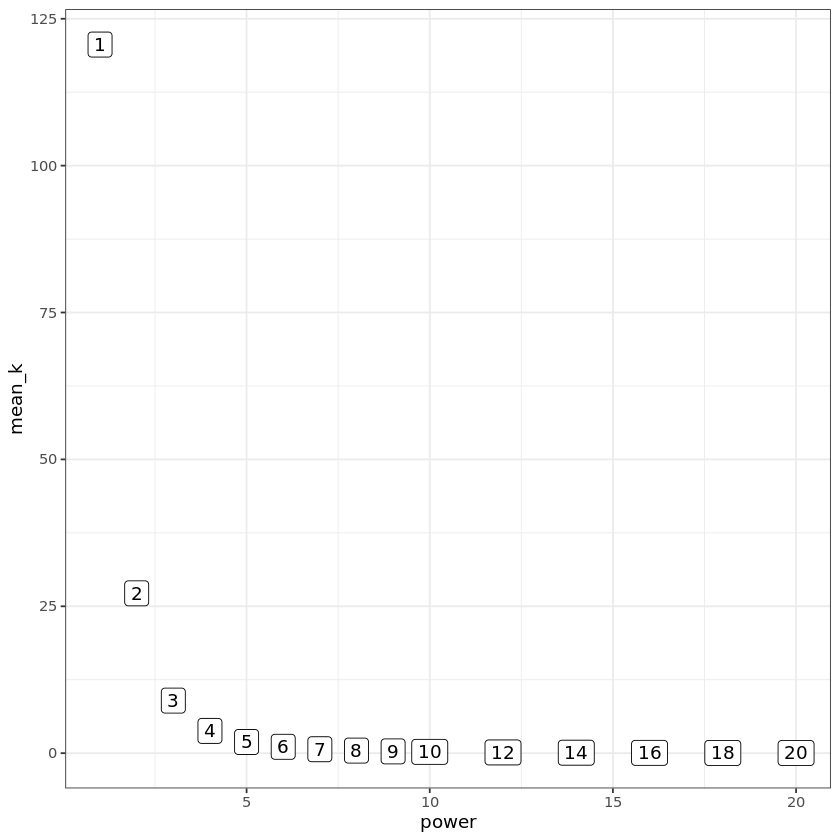

In [202]:
# sft_df
plt_1 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = scale_free_topology, label = power)) +
    geom_hline(yintercept = 0.9, color = "red", linetype = "dashed") +
    theme_bw()
plt_2 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = mean_k, label = power)) +
    theme_bw()
# plot_grid(plt_1, plt_2, labels = c("A", "B"), rows = 1, align="h")
plt_1
plt_2

## Pick soft thresholding power

In [225]:
# Pick first power which yields close to 0.9 scale free topology
thresh <- 0.9
tol <- 1e-2

soft_power <- sft_df %>%
    dplyr::filter(abs(scale_free_topology - thresh) < tol) %>%
    top_n(n = 1, wt = desc(power)) %>%
    dplyr::pull(power)


# Adjacency

In [242]:
adj <- adjacency(
    matrisome_norm_counts_df %>% column_to_rownames("sample_name"), 
    power = soft_power, 
    corOptions = list(method = "pearson")
)

# Topological Overlap Matrix (TOM)

In [243]:
tom <- TOMsimilarity(adj)
diss_tom <- 1 - tom

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


# Cluster on TOM

In [245]:
gene_tree <- hclust(as.dist(diss_tom), method = "average")

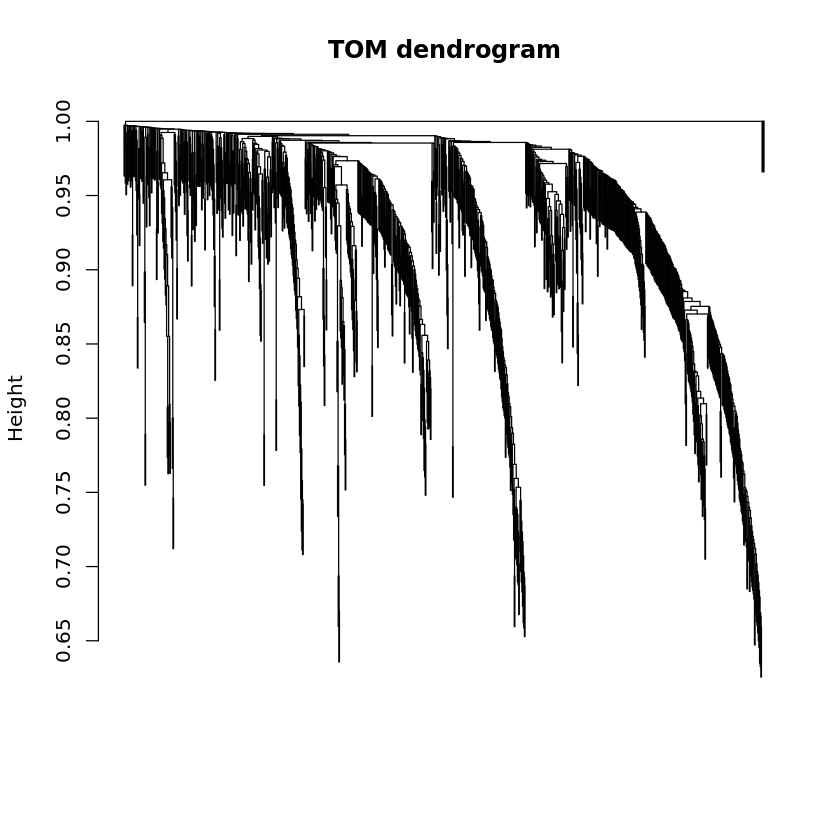

In [281]:
plot(gene_tree, labels = FALSE, xlab="", sub="", main = "TOM dendrogram")

In [300]:
# Set min. module size to 1/2 * min. matrisome category size
min_module_size <- filtered_matrisome_df %>%
    dplyr::group_by(category) %>%
    dplyr::summarize(n = n()) %>%
    top_n(n = 1, wt = desc(n)) %>%
    dplyr::pull(n) %>%
    (function(x) { x / 2 })

min_module_size

`summarise()` ungrouping output (override with `.groups` argument)


[1] 17.5

In [363]:
dynamic_mods <- cutreeDynamic(
    dendro = gene_tree, 
    distM = diss_tom, 
    deepSplit = TRUE, 
    pamRespectsDendro = FALSE, 
    minClusterSize = min_module_size
)
table(dynamic_mods)

 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamic_mods
  0   1   2   3   4   5   6   7   8   9  10 
  4 304 189 132 125  69  53  42  33  29  28 

In [364]:
# Good candidate for Sankey?
dynamic_mods %>%
    as_tibble() %>%
    dplyr::rename(cluster = value) %>%
    dplyr::bind_cols(transpose_df(matrisome_norm_counts_df, future_colnames_col = "sample_name", previous_colnames_col = "geneID")) %>%
    dplyr::inner_join(matrisome_df, by = c("geneID" = "gene_symbol")) %>%
    dplyr::select(cluster, geneID, category) %>%
    dplyr::group_by(cluster, category) %>%
    summarize(n = n())

`summarise()` regrouping output by 'cluster' (override with `.groups` argument)


cluster,category,n
<dbl>,<chr>,<int>
0,ECM Glycoproteins,1
0,ECM-affiliated Proteins,1
0,Secreted Factors,2
1,Collagens,24
1,ECM Glycoproteins,83
1,ECM Regulators,68
1,ECM-affiliated Proteins,45
1,Proteoglycans,15
1,Secreted Factors,69
